# ML Pipeline Preparation
Follow the instructions below to help you create your ML pipeline.
### 1. Import libraries and load data from database.
- Import Python libraries
- Load dataset from database with [`read_sql_table`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_sql_table.html)
- Define feature and target variables X and Y

In [61]:
# import basic libraries
import os
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
from sqlalchemy import create_engine
# import nltk and text processing (like regular expresion) libraries
import nltk
nltk.download(['punkt', 'wordnet','stopwords'])
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
import re

# import libraries for transformation
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer

# import machine learning libraries
from sklearn.datasets import make_multilabel_classification
from sklearn.multioutput import MultiOutputClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, fbeta_score, make_scorer
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.ensemble import RandomForestClassifier
stop_words = stopwords.words("english")
lemmatizer = WordNetLemmatizer()

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [62]:
# load data from database
db_file = "./CleanDisasterResponse.db"
# create the connection to the DB
engine = create_engine('sqlite:///CleanDisasterResponse.db')
# prepare a table name
table_name = os.path.basename(db_file).replace(".db","")
# load the info from the sql table into a pandas file
df = pd.read_sql_table(table_name,engine)

# Exploratory Data Analysis (EDA)

Let's do some Exploratory Data Analysis.
First of all we'll see an overview of the dataset

In [65]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26216 entries, 0 to 26215
Data columns (total 40 columns):
id                        26216 non-null int64
message                   26216 non-null object
original                  10170 non-null object
genre                     26216 non-null object
related                   26216 non-null int64
request                   26216 non-null int64
offer                     26216 non-null int64
aid_related               26216 non-null int64
medical_help              26216 non-null int64
medical_products          26216 non-null int64
search_and_rescue         26216 non-null int64
security                  26216 non-null int64
military                  26216 non-null int64
child_alone               26216 non-null int64
water                     26216 non-null int64
food                      26216 non-null int64
shelter                   26216 non-null int64
clothing                  26216 non-null int64
money                     26216 non-null i

In [66]:
df.describe()

,id,related,request,offer,aid_related,medical_help,medical_products,search_and_rescue,security,military,...,aid_centers,other_infrastructure,weather_related,floods,storm,fire,earthquake,cold,other_weather,direct_report
count,26216.00000,26216.000000,26216.000000,26216.000000,26216.000000,26216.000000,26216.000000,26216.000000,26216.000000,26216.000000,...,26216.000000,26216.000000,26216.000000,26216.000000,26216.000000,26216.000000,26216.000000,26216.000000,26216.000000,26216.000000
mean,15224.82133,0.773650,0.170659,0.004501,0.414251,0.079493,0.050084,0.027617,0.017966,0.032804,...,0.011787,0.043904,0.278341,0.082202,0.093187,0.010757,0.093645,0.020217,0.052487,0.193584
std,8826.88914,0.435276,0.376218,0.066940,0.492602,0.270513,0.218122,0.163875,0.132831,0.178128,...,0.107927,0.204887,0.448191,0.274677,0.290700,0.103158,0.291340,0.140743,0.223011,0.395114
min,2.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,7446.75000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,15662.50000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,22924.25000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,30265.00000,2.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


We can see there are 40 columns and 26216 entries and our dataset has a memory usage: of 8.0+ MB
The dataset is pretty complete, with almost all its values (non-null).
There are three string fields and the rest of fields are of type integer
If we look at the fields, the major part of them are values between [0-1] except the "id" field and the "related" field whose values are between [0-2]

Now we'll check the 10 first lines of the dataset

In [67]:
df.head(10)

,id,message,original,genre,related,request,offer,aid_related,medical_help,medical_products,...,aid_centers,other_infrastructure,weather_related,floods,storm,fire,earthquake,cold,other_weather,direct_report
0,2,Weather update - a cold front from Cuba that c...,Un front froid se retrouve sur Cuba ce matin. ...,direct,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,7,Is the Hurricane over or is it not over,Cyclone nan fini osinon li pa fini,direct,1,0,0,1,0,0,...,0,0,1,0,1,0,0,0,0,0
2,8,Looking for someone but no name,"Patnm, di Maryani relem pou li banm nouvel li ...",direct,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,9,UN reports Leogane 80-90 destroyed. Only Hospi...,UN reports Leogane 80-90 destroyed. Only Hospi...,direct,1,1,0,1,0,1,...,0,0,0,0,0,0,0,0,0,0
4,12,"says: west side of Haiti, rest of the country ...",facade ouest d Haiti et le reste du pays aujou...,direct,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,14,Information about the National Palace-,Informtion au nivaux palais nationl,direct,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,15,Storm at sacred heart of jesus,Cyclone Coeur sacr de jesus,direct,1,0,0,0,0,0,...,0,0,1,0,1,0,0,0,0,0
7,16,"Please, we need tents and water. We are in Sil...",Tanpri nou bezwen tant avek dlo nou zon silo m...,direct,1,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1
8,17,"I would like to receive the messages, thank you",Mwen ta renmen jouin messag yo. Merci,direct,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,18,I am in Croix-des-Bouquets. We have health iss...,"Nou kwadebouke, nou gen pwoblem sant m yo nan ...",direct,1,1,0,1,1,1,...,0,0,0,0,0,0,0,0,0,1


Now let's see how many records of every "related" field are. 
We will use these query for the final visualization part

In [68]:
df.groupby("related").count()

,id,message,original,genre,request,offer,aid_related,medical_help,medical_products,search_and_rescue,...,aid_centers,other_infrastructure,weather_related,floods,storm,fire,earthquake,cold,other_weather,direct_report
related,,,,,,,,,,,,,,,,,,,,,
0,6122,6122,3395,6122,6122,6122,6122,6122,6122,6122,...,6122,6122,6122,6122,6122,6122,6122,6122,6122,6122
1,19906,19906,6643,19906,19906,19906,19906,19906,19906,19906,...,19906,19906,19906,19906,19906,19906,19906,19906,19906,19906
2,188,188,132,188,188,188,188,188,188,188,...,188,188,188,188,188,188,188,188,188,188


## Pearson correlation between variables
Let's build a heatmap, to see the correlation of each variable

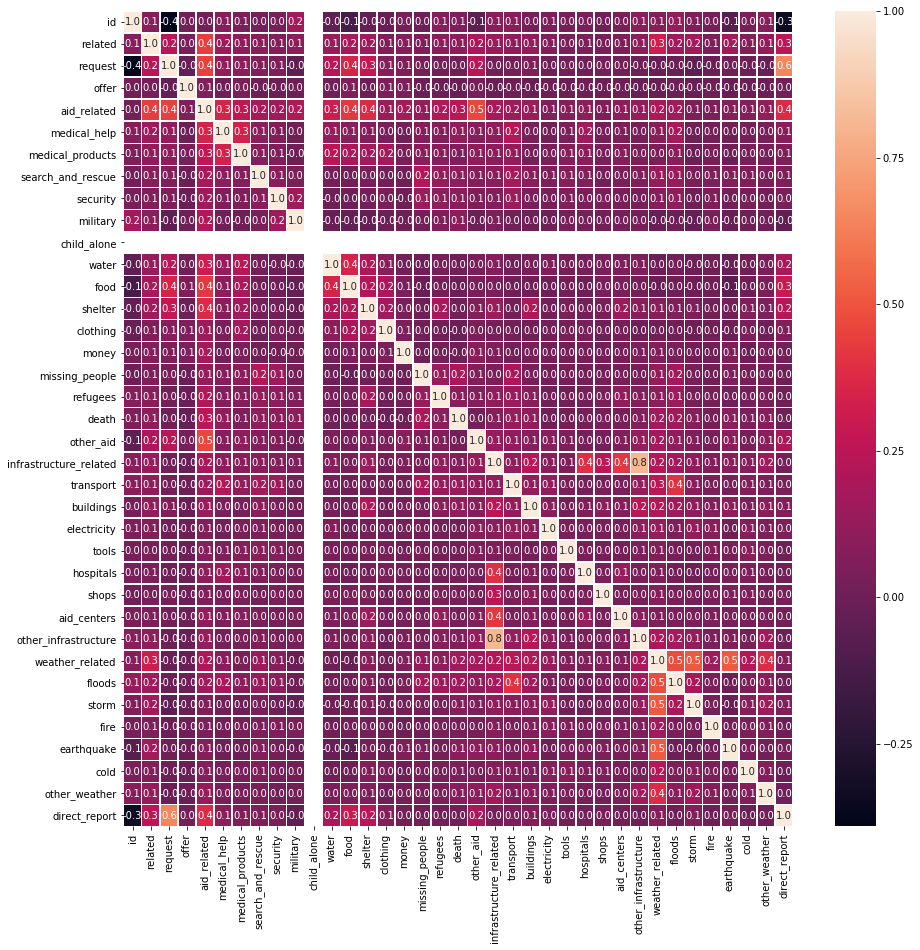

In [76]:
data = df.copy()
f,ax = plt.subplots(figsize=(15, 15))
sns.heatmap(data.corr(), annot=True, linewidths=.5, fmt= '.1f',ax=ax)
plt.show()

We have a glimpse of the data!!

Now, we will start with the Machine Learning tasks

In [39]:
# We separate the features from the variables we are going to predict
X = df ['message']
y = df.drop(columns = ['id', 'message', 'original', 'genre'])

### 2. Tokenization function to process your text data

In [40]:
def tokenize(text):
    # normalize case and remove punctuation
    text = re.sub(r"[^a-zA-Z0-9]", " ", text.lower())
    
    # tokenize text
    tokens = word_tokenize(text)
    
    # lemmatize andremove stop words
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]

    return tokens

### 3. Build a machine learning pipeline
This machine pipeline should take in the `message` column as input and output classification results on the other 36 categories in the dataset. You may find the [MultiOutputClassifier](http://scikit-learn.org/stable/modules/generated/sklearn.multioutput.MultiOutputClassifier.html) helpful for predicting multiple target variables.

In [10]:
pipeline = Pipeline([
        ('vect', CountVectorizer(tokenizer=tokenize)),
        ('tfidf', TfidfTransformer()),
        ('clf', MultiOutputClassifier (RandomForestClassifier())) 
    ])

### 4. Train pipeline
- Split data into train and test sets
- Train pipeline

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y)

# train classifier
pipeline.fit(X_train, y_train) 

Pipeline(memory=None,
     steps=[('vect', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip...oob_score=False, random_state=None, verbose=0,
            warm_start=False),
           n_jobs=1))])

### 5. Test your model
Report the f1 score, precision and recall for each output category of the dataset. You can do this by iterating through the columns and calling sklearn's `classification_report` on each.

In [13]:
# predict on test data
y_pred = pipeline.predict(X_test)

In [14]:
# we check dimensions
X_train.shape, y_train.shape, y.shape, X.shape

((19662,), (19662, 36), (26216, 36), (26216,))

In [15]:
# and print metrics
accuracy = (y_pred == y_test).mean()
print("Accuracy:", accuracy, "\n")

category_names = list(y.columns)

for i in range(len(category_names)):
    print("Output Category:", category_names[i],"\n", classification_report(y_test.iloc[:, i].values, y_pred[:, i]))
    print('Accuracy of %25s: %.2f' %(category_names[i], accuracy_score(y_test.iloc[:, i].values, y_pred[:,i])))


Accuracy: related                   0.801190
request                   0.884040
offer                     0.995270
aid_related               0.750229
medical_help              0.921422
medical_products          0.951633
search_and_rescue         0.971468
security                  0.983216
military                  0.968874
child_alone               1.000000
water                     0.954837
food                      0.937443
shelter                   0.930119
clothing                  0.983522
money                     0.977266
missing_people            0.989319
refugees                  0.967806
death                     0.961092
other_aid                 0.867867
infrastructure_related    0.931492
transport                 0.959567
buildings                 0.956515
electricity               0.978944
tools                     0.992524
hospitals                 0.988557
shops                     0.995423
aid_centers               0.987946
other_infrastructure      0.954532
weather_re

/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


### 6. Improve your model
Use grid search to find better parameters. 

In [ ]:
base = Pipeline([
        ('vect', CountVectorizer(tokenizer=tokenize)),
        ('tfidf', TfidfTransformer()),
        ('clf', MultiOutputClassifier(RandomForestClassifier()))
        ])
    
parameters = {'clf__estimator__n_estimators': [10, 20],
              'clf__estimator__max_depth': [2, 5],
              'clf__estimator__min_samples_split': [2, 3, 4],
              'clf__estimator__criterion': ['entropy']
                 }
    
cv = GridSearchCV(base, param_grid=parameters, n_jobs=-1, cv=2, verbose=3)

In [18]:
cv.fit(X_train, y_train)

Fitting 2 folds for each of 4 candidates, totalling 8 fits
[CV] clf__estimator__criterion=entropy, clf__estimator__max_depth=2, clf__estimator__n_estimators=10 
[CV]  clf__estimator__criterion=entropy, clf__estimator__max_depth=2, clf__estimator__n_estimators=10, score=0.19265588444715695, total=  10.2s
[CV] clf__estimator__criterion=entropy, clf__estimator__max_depth=2, clf__estimator__n_estimators=10 


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   14.9s remaining:    0.0s


[CV]  clf__estimator__criterion=entropy, clf__estimator__max_depth=2, clf__estimator__n_estimators=10, score=0.1936730749669413, total=  10.4s
[CV] clf__estimator__criterion=entropy, clf__estimator__max_depth=2, clf__estimator__n_estimators=20 


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:   30.0s remaining:    0.0s


[CV]  clf__estimator__criterion=entropy, clf__estimator__max_depth=2, clf__estimator__n_estimators=20, score=0.19316447970704914, total=  11.8s
[CV] clf__estimator__criterion=entropy, clf__estimator__max_depth=2, clf__estimator__n_estimators=20 
[CV]  clf__estimator__criterion=entropy, clf__estimator__max_depth=2, clf__estimator__n_estimators=20, score=0.19377479401891975, total=  11.6s
[CV] clf__estimator__criterion=entropy, clf__estimator__max_depth=5, clf__estimator__n_estimators=10 
[CV]  clf__estimator__criterion=entropy, clf__estimator__max_depth=5, clf__estimator__n_estimators=10, score=0.19204557013528634, total=  10.5s
[CV] clf__estimator__criterion=entropy, clf__estimator__max_depth=5, clf__estimator__n_estimators=10 
[CV]  clf__estimator__criterion=entropy, clf__estimator__max_depth=5, clf__estimator__n_estimators=10, score=0.19092666056352356, total=  10.5s
[CV] clf__estimator__criterion=entropy, clf__estimator__max_depth=5, clf__estimator__n_estimators=20 
[CV]  clf__estim

[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:  2.2min finished


GridSearchCV(cv=2, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('vect', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip...oob_score=False, random_state=None, verbose=0,
            warm_start=False),
           n_jobs=1))]),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'clf__estimator__n_estimators': [10, 20], 'clf__estimator__max_depth': [2, 5], 'clf__estimator__criterion': ['entropy']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=3)

### 7. Test your model
Show the accuracy, precision, and recall of the tuned model.  

Since this project focuses on code quality, process, and  pipelines, there is no minimum performance metric needed to pass. However, make sure to fine tune your models for accuracy, precision and recall to make your project stand out - especially for your portfolio!

In [49]:
y_pred = cv.predict(X_test)

In [20]:
accuracy = (y_pred == y_test).mean()
print("Accuracy:", accuracy, "\n")
for i in range(len(category_names)):
    print("Output Category:", category_names[i],"\n", classification_report(y_test.iloc[:, i].values, y_pred[:, i]))
    print('Accuracy of %25s: %.2f' %(category_names[i], accuracy_score(y_test.iloc[:, i].values, y_pred[:,i])))


Accuracy: related                   0.801190
request                   0.884040
offer                     0.995270
aid_related               0.750229
medical_help              0.921422
medical_products          0.951633
search_and_rescue         0.971468
security                  0.983216
military                  0.968874
child_alone               1.000000
water                     0.954837
food                      0.937443
shelter                   0.930119
clothing                  0.983522
money                     0.977266
missing_people            0.989319
refugees                  0.967806
death                     0.961092
other_aid                 0.867867
infrastructure_related    0.931492
transport                 0.959567
buildings                 0.956515
electricity               0.978944
tools                     0.992524
hospitals                 0.988557
shops                     0.995423
aid_centers               0.987946
other_infrastructure      0.954532
weather_re

/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


### 8. Try improving your model further. Here are a few ideas:
* try other machine learning algorithms
* add other features besides the TF-IDF

In [43]:
from sklearn.decomposition import TruncatedSVD
import sklearn

base = Pipeline([
                ('countvec',CountVectorizer(tokenizer=tokenize)),
                ('tfidf', TfidfTransformer()),
                ('lsa', TruncatedSVD(random_state=42, n_components=100)),
                ('clf', MultiOutputClassifier(sklearn.svm.SVC(random_state=42, class_weight='balanced', gamma='scale')))
           ])

# SVC parameters
parameters = {
    'clf__estimator__kernel': ['linear', 'rbf'],
    'clf__estimator__C': [0.1, 1, 5]
    }

cv = GridSearchCV(base, parameters, cv=2, scoring='f1_samples')

In [45]:
cv.fit(X_train, y_train)

Fitting 2 folds for each of 12 candidates, totalling 24 fits
[CV] clf__estimator__criterion=entropy, clf__estimator__max_depth=2, clf__estimator__min_samples_split=2, clf__estimator__n_estimators=10 
[CV]  clf__estimator__criterion=entropy, clf__estimator__max_depth=2, clf__estimator__min_samples_split=2, clf__estimator__n_estimators=10, score=0.1927576034991354, total=  10.5s
[CV] clf__estimator__criterion=entropy, clf__estimator__max_depth=2, clf__estimator__min_samples_split=2, clf__estimator__n_estimators=10 


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   15.2s remaining:    0.0s


[CV]  clf__estimator__criterion=entropy, clf__estimator__max_depth=2, clf__estimator__min_samples_split=2, clf__estimator__n_estimators=10, score=0.19397823212287663, total=  10.4s
[CV] clf__estimator__criterion=entropy, clf__estimator__max_depth=2, clf__estimator__min_samples_split=2, clf__estimator__n_estimators=20 


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:   30.3s remaining:    0.0s


[CV]  clf__estimator__criterion=entropy, clf__estimator__max_depth=2, clf__estimator__min_samples_split=2, clf__estimator__n_estimators=20, score=0.19296104160309227, total=  11.8s
[CV] clf__estimator__criterion=entropy, clf__estimator__max_depth=2, clf__estimator__min_samples_split=2, clf__estimator__n_estimators=20 
[CV]  clf__estimator__criterion=entropy, clf__estimator__max_depth=2, clf__estimator__min_samples_split=2, clf__estimator__n_estimators=20, score=0.19397823212287663, total=  11.8s
[CV] clf__estimator__criterion=entropy, clf__estimator__max_depth=2, clf__estimator__min_samples_split=3, clf__estimator__n_estimators=10 
[CV]  clf__estimator__criterion=entropy, clf__estimator__max_depth=2, clf__estimator__min_samples_split=3, clf__estimator__n_estimators=10, score=0.1930627606550707, total=  10.4s
[CV] clf__estimator__criterion=entropy, clf__estimator__max_depth=2, clf__estimator__min_samples_split=3, clf__estimator__n_estimators=10 
[CV]  clf__estimator__criterion=entropy, 

[Parallel(n_jobs=-1)]: Done  24 out of  24 | elapsed:  6.5min finished


GridSearchCV(cv=2, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('vect', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip...oob_score=False, random_state=None, verbose=0,
            warm_start=False),
           n_jobs=1))]),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'clf__estimator__n_estimators': [10, 20], 'clf__estimator__max_depth': [2, 5], 'clf__estimator__min_samples_split': [2, 3, 4], 'clf__estimator__criterion': ['entropy']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=3)

In [47]:
y_pred = cv.predict(X_test)

In [48]:
accuracy = (y_pred == y_test).mean()
print("Accuracy:", accuracy, "\n")

category_names = list(y.columns)

for i in range(len(category_names)):
    print("Output Category:", category_names[i],"\n", classification_report(y_test.iloc[:, i].values, y_pred[:, i]))
    print('Accuracy of %25s: %.2f' %(category_names[i], accuracy_score(y_test.iloc[:, i].values, y_pred[:,i])))

Accuracy: related                   0.765639
request                   0.829722
offer                     0.995423
aid_related               0.587122
medical_help              0.919286
medical_products          0.950717
search_and_rescue         0.971468
security                  0.982911
military                  0.966738
child_alone               1.000000
water                     0.935917
food                      0.889838
shelter                   0.913488
clothing                  0.982453
money                     0.976808
missing_people            0.989167
refugees                  0.967501
death                     0.954074
other_aid                 0.868630
infrastructure_related    0.932865
transport                 0.958651
buildings                 0.952853
electricity               0.977724
tools                     0.992524
hospitals                 0.988557
shops                     0.995423
aid_centers               0.987946
other_infrastructure      0.954837
weather_re

/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


### 9. Export your model as a pickle file

In [28]:
def save_model(model, model_filepath):
    """
    Save the model as a pickle file:

    This procedure saves the model as a pickle file

    Args: model, X set, y set

    Returns:
        nothing, it runs the model and it displays accuracy metrics
    """
    try:        
        pickle.dump(model, open(model_filepath, 'wb'))
    except:
        print("Error saving the model as a {} pickle file".format(model_filepath))

In [29]:
save_model(cv,"classifier5.pkl")

In [30]:
pickle.dump(cv, open("classifier5.pkl", 'wb'))

### 10. Use this notebook to complete `train.py`
Use the template file attached in the Resources folder to write a script that runs the steps above to create a database and export a model based on a new dataset specified by the user.

# Refactoring

In [24]:
 def load_data(db_file):
    """
    Load data function
    
    This method receives a database file on a path and it loads data 
    from that database file into a pandas datafile.
    It also splits the data into X and y (X: features to work and y: labels to predict)   
    It returns two sets of data: X and y
      
    Args: 
        db_file (str): Filepath where database is stored.
    
    Returns: 
        X (DataFrame): Feature columns
        y (DataFrame): Label columns
    
    """
    # load data from database
    # db_file = "./CleanDisasterResponse.db"
    # create the connection to the DB
    engine = create_engine('sqlite:///{}'.format(db_file))
    table_name = os.path.basename(db_file).replace(".db","")
    # load the info from the sql table into a pandas file
    df = pd.read_sql_table(table_name,engine)
    # We separate the features from the variables we are going to predict
    X = df ['message']
    y = df.drop(columns = ['id', 'message', 'original', 'genre'])

    return X, y

In [ ]:
def display_results(y_test, y_pred):
    labels = np.unique(y_pred)
    confusion_mat = confusion_matrix(y_test, y_pred, labels=labels)
    accuracy = (y_pred == y_test).mean()

    print("Labels:", labels)
    print("Confusion Matrix:\n", confusion_mat)
    print("Accuracy:", accuracy)

In [28]:
A,b = load_data("./CleanDisasterResponse.db")

,related,request,offer,aid_related,medical_help,medical_products,search_and_rescue,security,military,child_alone,...,aid_centers,other_infrastructure,weather_related,floods,storm,fire,earthquake,cold,other_weather,direct_report
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,1,0,0,0,0,0,0,...,0,0,1,0,1,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,1,0,1,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,1,0,0,0,0,0,0,0,0,0,...,0,0,1,0,1,0,0,0,0,0
7,1,1,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
8,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,1,1,0,1,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [18]:
def tokenize(text):
    """
    Tokenize function
    
    Args:
        This method receives a text and it tokenizes it   
    
    Returns: a set of tokens
    
    """
    # normalize case and remove punctuation
    text = re.sub(r"[^a-zA-Z0-9]", " ", text.lower())
    
    # tokenize text
    tokens = word_tokenize(text)
    
    # lemmatize andremove stop words
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]

    return tokens

In [29]:
def save_model(model, model_filepath):
    """
    Save the model as a pickle file:

    This procedure saves the model as a pickle file

    Args: model, X set, y set

    Returns:
        nothing, it runs the model and it displays accuracy metrics
    """
    pickle.dump(model, open(model_filepath, 'wb'))

And now let's try some queries to show interesting data on the html web

In [7]:
top_10_mes = df.iloc[:,5:].sum().sort_values(ascending=False)[0:10]
top_10_mes
top_10_mes_names = list(top_10_mes.index)
top_10_mes_names

['aid_related',
 'weather_related',
 'direct_report',
 'request',
 'other_aid',
 'food',
 'earthquake',
 'storm',
 'shelter',
 'floods']

In [8]:
mes_categories = df.columns[5:-1]
mes_categories

Index(['request', 'offer', 'aid_related', 'medical_help', 'medical_products',
       'search_and_rescue', 'security', 'military', 'child_alone', 'water',
       'food', 'shelter', 'clothing', 'money', 'missing_people', 'refugees',
       'death', 'other_aid', 'infrastructure_related', 'transport',
       'buildings', 'electricity', 'tools', 'hospitals', 'shops',
       'aid_centers', 'other_infrastructure', 'weather_related', 'floods',
       'storm', 'fire', 'earthquake', 'cold', 'other_weather'],
      dtype='object')

In [9]:
mes_categories_count = df[mes_categories].sum()
mes_categories_count

request                    4474
offer                       118
aid_related               10860
medical_help               2084
medical_products           1313
search_and_rescue           724
security                    471
military                    860
child_alone                   0
water                      1672
food                       2923
shelter                    2314
clothing                    405
money                       604
missing_people              298
refugees                    875
death                      1194
other_aid                  3446
infrastructure_related     1705
transport                  1201
buildings                  1333
electricity                 532
tools                       159
hospitals                   283
shops                       120
aid_centers                 309
other_infrastructure       1151
weather_related            7297
floods                     2155
storm                      2443
fire                        282
earthqua

In [10]:
bottom_10_mes = df.iloc[:,5:].sum().sort_values()[0:10]
bottom_10_mes

child_alone         0
offer             118
shops             120
tools             159
fire              282
hospitals         283
missing_people    298
aid_centers       309
clothing          405
security          471
dtype: int64

In [11]:
bottom_10_mes_names = list(bottom_10_mes.index)
bottom_10_mes_names

['child_alone',
 'offer',
 'shops',
 'tools',
 'fire',
 'hospitals',
 'missing_people',
 'aid_centers',
 'clothing',
 'security']

In [12]:
distr_class_1 = df.drop(['id', 'message', 'original', 'genre'], axis = 1).sum()/len(df)

In [13]:
distr_class_1 = distr_class_1.sort_values(ascending = False)

In [14]:
distr_class_0 = 1 - distr_class_1

In [15]:
distr_class_names = list(distr_class_1.index)

In [16]:
list(distr_class_1.index)

['related',
 'aid_related',
 'weather_related',
 'direct_report',
 'request',
 'other_aid',
 'food',
 'earthquake',
 'storm',
 'shelter',
 'floods',
 'medical_help',
 'infrastructure_related',
 'water',
 'other_weather',
 'buildings',
 'medical_products',
 'transport',
 'death',
 'other_infrastructure',
 'refugees',
 'military',
 'search_and_rescue',
 'money',
 'electricity',
 'cold',
 'security',
 'clothing',
 'aid_centers',
 'missing_people',
 'hospitals',
 'fire',
 'tools',
 'shops',
 'offer',
 'child_alone']

In [17]:
distr_class_1 = df.drop(['id', 'message', 'original', 'genre'], axis = 1).sum()/len(df)